### On travaille à partir du code ""optim_adrs.py". Ce code repose sur la minimisation d'une fonctionnelle J qui permet de mesurer la différence entre une solution numérique et une solution donnée. On donne un nouveau code qui permet de visualiser J en faisant varier deux paramètres et en laissant les autres fixés. 

Évaluation de J: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.17it/s]


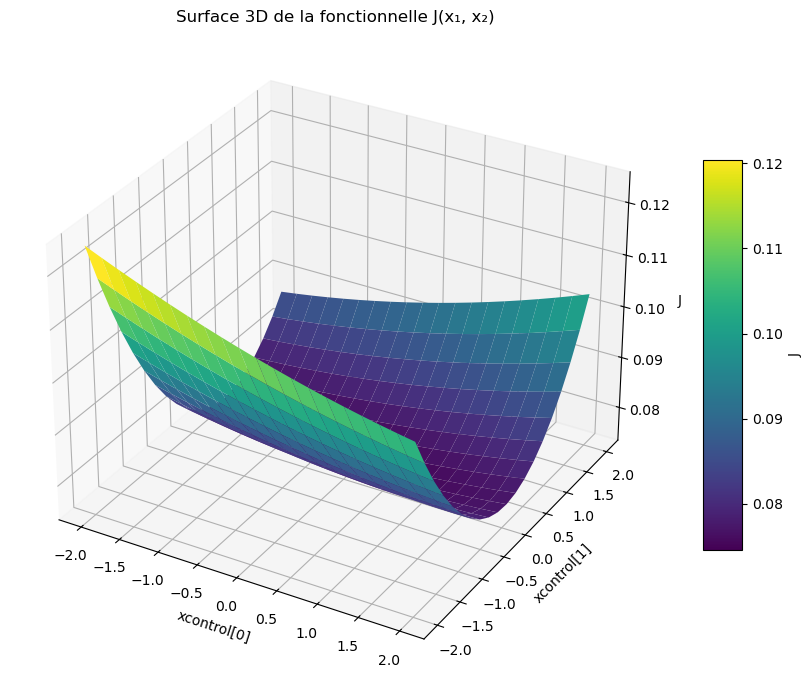

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm  # pip install tqdm si nécessaire

# ==========================================================
# ============= 1. FONCTION ADRS (corrigée & rapide) =======
# ==========================================================
def ADRS(NX, xcontrol, Target, NT=300):
    K = 0.1
    L = 1.0
    V = 1.0
    lamda = 1.0
    eps = 1e-4

    dx = L / (NX - 1)
    dt = 0.5 * dx**2 / (V*dx + 2*K + dx**2)

    x = np.linspace(0.0, L, NX)
    T = np.zeros(NX)
    RHS = np.zeros_like(T)

    # ==== Source term: sum of Gaussians ====
    centers = np.array([L / (ic + 1) for ic in range(len(xcontrol))])
    F = np.zeros_like(x)
    for ic, c in enumerate(centers):
        F += xcontrol[ic] * np.exp(-100 * (x - c)**2)

    res = 1.0
    res0 = 1.0
    n = 0

    while n < NT and res > eps * res0:
        n += 1
        Tx = (T[2:] - T[:-2]) / (2 * dx)
        Txx = (T[:-2] - 2*T[1:-1] + T[2:]) / dx**2
        RHS[1:-1] = dt * (-V * Tx + (K + 0.5 * dx * abs(V)) * Txx - lamda * T[1:-1] + F[1:-1])
        res = np.sum(np.abs(RHS[1:-1]))
        if n == 1:
            res0 = res
        T[1:-1] += RHS[1:-1]

        # Conditions aux bords
        T[0] = 0.0
        T[-1] = T[-2]

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T


# ==========================================================
# ============= 2. CONSTRUCTION DE LA CIBLE ================
# ==========================================================
NX_target = 200
x_target = np.linspace(0, 1, NX_target)
nbc_ref = 10
xcontrol_target = np.arange(nbc_ref) + 1
_, Target_fine = ADRS(NX_target, xcontrol_target, np.zeros(NX_target))

NX = 30
x_domain = np.linspace(0, 1, NX)
interp_target = interp1d(x_target, Target_fine, kind='linear')
Target = interp_target(x_domain)


# ==========================================================
# ============= 3. EXPLORATION DE J ========================
# ==========================================================
nbc = 4
ic1, ic2 = 0, 1
xcontrol_fixed = np.zeros(nbc)

val_range = np.linspace(-2, 2, 20)  # grille plus légère
X1, X2 = np.meshgrid(val_range, val_range)
J_values = np.zeros_like(X1)

for i in tqdm(range(X1.shape[0]), desc="Évaluation de J"):
    for j in range(X1.shape[1]):
        xcontrol = xcontrol_fixed.copy()
        xcontrol[ic1] = X1[i, j]
        xcontrol[ic2] = X2[i, j]
        J_values[i, j], _ = ADRS(NX, xcontrol, Target, NT=300)

# ==========================================================
# ============= 4. VISUALISATION 3D ========================
# ==========================================================
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, J_values, cmap='viridis', edgecolor='none')

ax.set_xlabel(f"xcontrol[{ic1}]")
ax.set_ylabel(f"xcontrol[{ic2}]")
ax.set_zlabel("J")
ax.set_title("Surface 3D de la fonctionnelle J(x₁, x₂)")
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label="J")

plt.tight_layout()
plt.show()


### On reprend le code "optim_adrs.py" et on le modifie pour afficher les courbes obtenues pour différents nombre de sources nbc.  On trace également l'erreur en fonction de nbc

nbc = 2, erreur L2 = 7.5839e-01
nbc = 3, erreur L2 = 5.7019e-01
nbc = 4, erreur L2 = 2.5106e-01
nbc = 5, erreur L2 = 6.8071e-02
nbc = 6, erreur L2 = 2.0113e-02
nbc = 7, erreur L2 = 1.5629e-02
nbc = 8, erreur L2 = 1.5595e-02
nbc = 9, erreur L2 = 1.5242e-02
nbc = 10, erreur L2 = 1.4826e-02


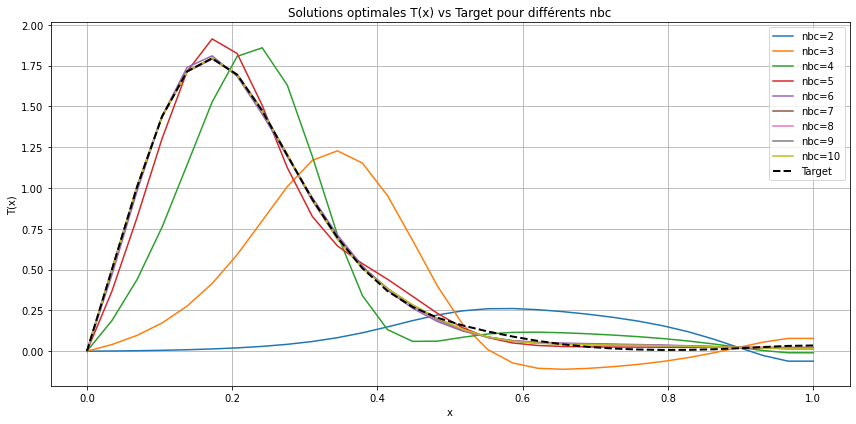

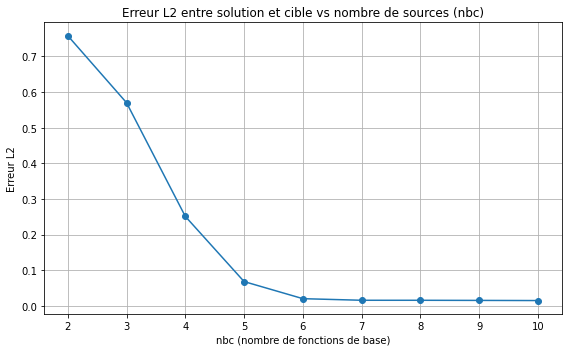

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def ADRS(NX, xcontrol, Target):
    K = 0.1
    L = 1.0
    V = 1.0
    lamda = 1.0
    NT = 1000
    eps = 1e-4

    dx = L / (NX - 1)
    dt = 0.5 * dx**2 / (V*dx + 2*K + dx**2)

    x = np.linspace(0.0, L, NX)
    T = np.zeros(NX)
    F = np.zeros(NX)
    RHS = np.zeros(NX)

    # Source term: sum of Gaussians
    for j in range(1, NX - 1):
        for ic in range(len(xcontrol)):
            F[j] += xcontrol[ic] * np.exp(-100 * (x[j] - L / (ic + 1))**2)

    res = 1.0
    res0 = 1.0
    n = 0
    while n < NT and res > eps * res0:
        n += 1
        res = 0
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j+1] - T[j-1]) / (2 * dx)
            Txx = (T[j-1] - 2*T[j] + T[j+1]) / dx**2
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        for j in range(1, NX - 1):
            T[j] += RHS[j]

        # Boundary conditions
        T[0] = 0.0            # Dirichlet
        T[-1] = T[-2]         # Neumann

        if n == 1:
            res0 = res

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T

# ==== CIBLE DE RÉFÉRENCE ====
NX_target = 200
x_target = np.linspace(0, 1, NX_target)
nbc_ref = 10
xcontrol_target = np.arange(nbc_ref) + 1
_, Target_fine = ADRS(NX_target, xcontrol_target, np.zeros(NX_target))

# ==== PARAMÈTRES DE L'ÉTUDE ====
nbc_list = range(2, 11)
NX = 30
x_domain = np.linspace(0, 1, NX)
interp_target = interp1d(x_target, Target_fine, kind='linear')
Target = interp_target(x_domain)

errors = []  # Stocke les erreurs pour le second graphique

# ==== PLOT 1 : Solutions pour chaque nbc ====
plt.figure(figsize=(12, 6))

for nbc in nbc_list:
    xcontrol0 = np.zeros(nbc)
    cost0, T0 = ADRS(NX, xcontrol0, Target)

    A = np.zeros((nbc, nbc))
    B = np.zeros(nbc)

    for ic in range(nbc):
        xic = np.zeros(nbc)
        xic[ic] = 1
        _, Tic = ADRS(NX, xic, Target)
        B[ic] = np.dot(Target - T0, Tic) / (NX - 1)
        for jc in range(ic + 1):
            _, Tjc = ADRS(NX, np.eye(nbc)[jc], Target)
            A[ic, jc] = np.dot(Tic, Tjc) / (NX - 1)
            A[jc, ic] = A[ic, jc]

    xopt = np.linalg.solve(A, B)
    _, Topt = ADRS(NX, xopt, Target)

    # Erreur L2
    error_L2 = np.sqrt(np.sum((Topt - Target)**2) / NX)
    errors.append(error_L2)

    print(f"nbc = {nbc}, erreur L2 = {error_L2:.4e}")

    # Courbe de solution pour ce nbc
    plt.plot(x_domain, Topt, label=f'nbc={nbc}')

# Trace la cible interpolée
plt.plot(x_domain, Target, '--k', linewidth=2, label="Target")
plt.title("Solutions optimales T(x) vs Target pour différents nbc")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== PLOT 2 : Erreur L2 vs nbc ====
plt.figure(figsize=(8, 5))
plt.plot(list(nbc_list), errors, marker='o')
plt.title("Erreur L2 entre solution et cible vs nombre de sources (nbc)")
plt.xlabel("nbc (nombre de fonctions de base)")
plt.ylabel("Erreur L2")
plt.grid(True)
plt.tight_layout()
plt.show()


nbc=2, cost_opt=4.4571e-01
nbc=3, cost_opt=5.2914e-02
nbc=4, cost_opt=1.0733e-02
nbc=5, cost_opt=6.5479e-03
nbc=6, cost_opt=6.2701e-03
nbc=7, cost_opt=5.9438e-03
nbc=8, cost_opt=5.5946e-03
nbc=9, cost_opt=5.2356e-03
nbc=10, cost_opt=4.8617e-03


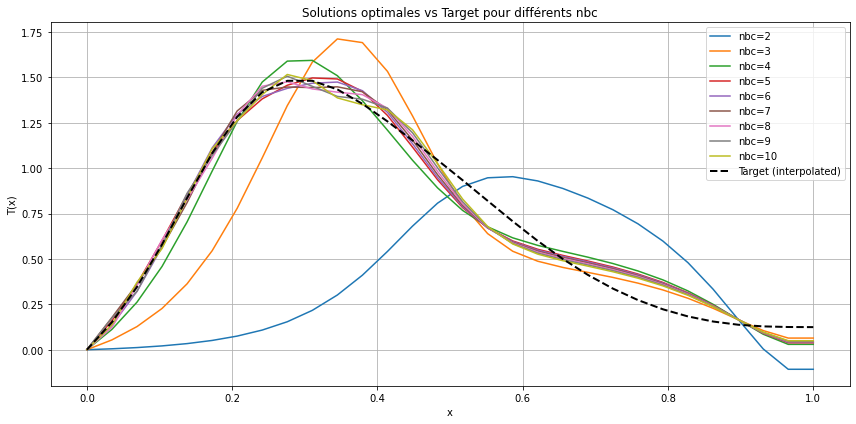

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

def ADRS(NX, xcontrol, Target):
    K = 0.1     # Diffusion coefficient
    L = 1.0     # Domain size
    V = 1.0     # Advection velocity
    lamda = 1.0 # Reaction coefficient
    Time = 20.0
    NT = 1000
    eps = 0.0001

    dx = L / (NX - 1)
    dt = 0.5 * dx**2 / (V*dx + 2*K + dx**2)  # CFL condition

    x = np.linspace(0.0, L, NX)
    T = np.zeros(NX)
    F = np.zeros(NX)
    RHS = np.zeros(NX)

    # Source term (sum of Gaussians)
    for j in range(1, NX-1):
        for ic in range(len(xcontrol)):
            F[j] += xcontrol[ic] * np.exp(-100 * (x[j] - L / (ic + 1))**2)

    # Time loop
    res = 1.0
    res0 = 1.0
    n = 0
    while n < NT and res > eps * res0:
        n += 1
        res = 0
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j+1] - T[j-1]) / (2 * dx)
            Txx = (T[j-1] - 2*T[j] + T[j+1]) / dx**2
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        for j in range(1, NX - 1):
            T[j] += RHS[j]

        # Apply boundary conditions
        T[0] = 0.0  # Dirichlet on the left
        T[-1] = T[-2]  # Neumann on the right: dT/dx = 0

        if n == 1:
            res0 = res

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T

# ==== PREPARE TARGET ====
NX_target = 100
x_target = np.linspace(0, 1, NX_target)
nbc_target = 6
xcible_target = np.arange(nbc_target) + 1
xcontrol_target = xcible_target  # some arbitrary distribution
_, Target_fine = ADRS(NX_target, xcontrol_target, np.zeros(NX_target))

# ==== LOOP OVER NBC ====
NX = 30
nbc_list = range(2, 11)  # from 2 to 10 sources
plt.figure(figsize=(12, 6))

for idx, nbc in enumerate(nbc_list):
    x_domain = np.linspace(0, 1, NX)
    
    # Interpolate fine target to current mesh
    f_interp = interp1d(x_target, Target_fine, kind='linear')
    Target = f_interp(x_domain)

    # Initial zero solution
    xcontrol0 = np.zeros(nbc)
    cost0, T0 = ADRS(NX, xcontrol0, Target)

    # Build matrix A and vector B
    A = np.zeros((nbc, nbc))
    B = np.zeros(nbc)

    Tics = []

    for ic in range(nbc):
        xic = np.zeros(nbc)
        xic[ic] = 1
        _, Tic = ADRS(NX, xic, Target)
        Tics.append(Tic)
        B[ic] = np.dot(Target - T0, Tic) / (NX - 1)
        for jc in range(ic + 1):
            _, Tjc = ADRS(NX, np.eye(nbc)[jc], Target)
            A[ic, jc] = np.dot(Tic, Tjc) / (NX - 1)
            A[jc, ic] = A[ic, jc]  # Symmetric

    # Solve system
    xopt = np.linalg.solve(A, B)
    cost_opt, Topt = ADRS(NX, xopt, Target)

    print(f"nbc={nbc}, cost_opt={cost_opt:.4e}")

    # Plot result
    plt.plot(x_domain, Topt, label=f'nbc={nbc}')

# Plot target
plt.plot(x_domain, Target, '--k', label="Target (interpolated)", linewidth=2)
plt.title("Solutions optimales vs Target pour différents nbc")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### On reprend le même procédé mais pour une cible sinusoidale qui est non admissible

nbc=2, cost_opt=3.9086e-01
nbc=3, cost_opt=7.5058e-02
nbc=4, cost_opt=5.4719e-02
nbc=5, cost_opt=3.7736e-02
nbc=6, cost_opt=3.7243e-02
nbc=7, cost_opt=3.4415e-02
nbc=8, cost_opt=3.2543e-02
nbc=9, cost_opt=3.0438e-02
nbc=10, cost_opt=2.8335e-02


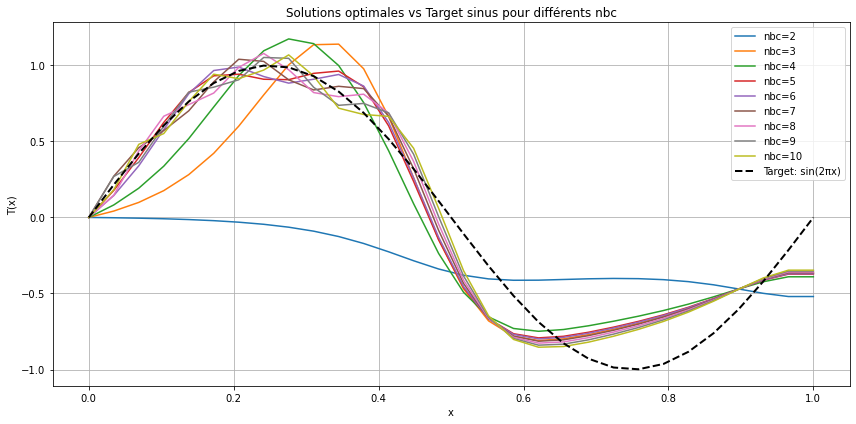

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

def ADRS(NX, xcontrol, Target):
    K = 0.1     # Diffusion coefficient
    L = 1.0     # Domain size
    V = 1.0     # Advection velocity
    lamda = 1.0 # Reaction coefficient
    Time = 20.0
    NT = 1000
    eps = 0.0001

    dx = L / (NX - 1)
    dt = 0.5 * dx**2 / (V*dx + 2*K + dx**2)  # CFL condition

    x = np.linspace(0.0, L, NX)
    T = np.zeros(NX)
    F = np.zeros(NX)
    RHS = np.zeros(NX)

    # Source term (sum of Gaussians)
    for j in range(1, NX-1):
        for ic in range(len(xcontrol)):
            F[j] += xcontrol[ic] * np.exp(-100 * (x[j] - L / (ic + 1))**2)

    # Time loop
    res = 1.0
    res0 = 1.0
    n = 0
    while n < NT and res > eps * res0:
        n += 1
        res = 0
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j+1] - T[j-1]) / (2 * dx)
            Txx = (T[j-1] - 2*T[j] + T[j+1]) / dx**2
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        for j in range(1, NX - 1):
            T[j] += RHS[j]

        # Boundary conditions
        T[0] = 0.0  # Dirichlet at x=0
        T[-1] = T[-2]  # Neumann at x=1

        if n == 1:
            res0 = res

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T

# ==== DEFINITION DE LA CIBLE : SINUS ====
NX_target = 200  # maillage très fin pour la référence
x_target = np.linspace(0, 1, NX_target)
Target_fine = np.sin(2 * np.pi * x_target)  # CIBLE : sinus

# ==== LOOP OVER NBC ====
NX = 30
nbc_list = range(2, 11)  # from 2 to 10 sources
plt.figure(figsize=(12, 6))

for idx, nbc in enumerate(nbc_list):
    x_domain = np.linspace(0, 1, NX)

    # Interpolate target to current mesh
    f_interp = interp1d(x_target, Target_fine, kind='linear')
    Target = f_interp(x_domain)

    # Initial zero control
    xcontrol0 = np.zeros(nbc)
    cost0, T0 = ADRS(NX, xcontrol0, Target)

    # Build system A·x = B
    A = np.zeros((nbc, nbc))
    B = np.zeros(nbc)
    Tics = []

    for ic in range(nbc):
        xic = np.zeros(nbc)
        xic[ic] = 1
        _, Tic = ADRS(NX, xic, Target)
        Tics.append(Tic)
        B[ic] = np.dot(Target - T0, Tic) / (NX - 1)
        for jc in range(ic + 1):
            _, Tjc = ADRS(NX, np.eye(nbc)[jc], Target)
            A[ic, jc] = np.dot(Tic, Tjc) / (NX - 1)
            A[jc, ic] = A[ic, jc]  # Symmetric

    # Solve for optimal coefficients
    xopt = np.linalg.solve(A, B)
    cost_opt, Topt = ADRS(NX, xopt, Target)

    print(f"nbc={nbc}, cost_opt={cost_opt:.4e}")

    # Plot
    plt.plot(x_domain, Topt, label=f'nbc={nbc}')

# Plot target
plt.plot(x_domain, Target, '--k', label="Target: sin(2πx)", linewidth=2)
plt.title("Solutions optimales vs Target sinus pour différents nbc")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### On observe des résultats assez mauvais. C'était attendu car la cible est non admisible.